In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 7)
import seaborn as sns
sns.set(font="AppleGothic", 
        rc={"axes.unicode_minus":False})
import os

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier\
, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix

from xgboost import XGBClassifier

### 앙상블(Esemble)
- 보팅(Voting)
    - 여러 종류의 알고리즘을 사용한 각각의 결과에 대해 투표를 통해 최종 결과를 예측하는 방식

- 배깅(Bagging, bootstrap aggregating)
    - bootstrap: 모집단의 성질에 대해 표본을 통해 추정할 수 있는 것처럼, 표본의 성질에 대해서도 재표집(resampling)을 통해 추정할 수 있다는 것
    - 같은 알고리즘에 대해 데이터 샘플을 다르게 두고 학습을 수행해 보팅을 수행하는 방식
    - 데이터 샘플은 중첩이 허용된다. 예를들어 1000개의 데이터에 대해 10개의 알고리즘이 배깅을 사용할 때, 각 1000개의 데이터 내에는 중복된 데이터가 존재할 수 있다.
    - 열은 모두 선택하되, 행은 표본을 추출해서 각 표본별로 개별적으로 트리를 적합화한다.

- 부스팅(Boosting)
    - 여러 개의 알고리즘이 순차적으로 학습을 하되, 앞에 학습한 알고리즘 예측이 틀린 데이터에 대해 올바르게 예측할 수 있도록, 그 다음 알고리즘에 가중치를 부여하여 학습과 예측을 진행하는 방식, 잔여오차를 다시 학습

### 보팅(Voting)
- hard voting: 개별 분류기에서 가장 많이 나온 다수를 범주로 선택하는 방법, 회귀 문제에서는 실제값을 평균해 취한다
- soft voting: 개별 분류기에서 확률을 구하고 확률의 평균이 높은 값을 선택하는 방법

#### hard voting
- 분류기들의 예측값이 1, 0, 0, 1, 1 이라고 한다면 1이 3개, 0이 2개이기 때문에 1을 최종 값으로 예측하게 된다.

#### soft voting
- 분류기들의 예측값이 0이 나올 확률: (0.4, 0.9, 0.9, 0.4, 0.4), 1이 나올 확률: (0.6, 0.1, 0.1, 0.6, 0.6) 이라면 0일 확률의 평균: 0.44, 1일 확률 평균: 0.4로 0을 최종 값으로 예측하게 된다.

In [2]:
# 유방암 데이터 불러오기
b_cancer = load_breast_cancer()

In [3]:
# 유방암 데이터 정보
print(b_cancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [4]:
# 트레인, 테스트셋 구성
x_train, x_test, y_train, y_test = train_test_split(b_cancer['data'], b_cancer['target'], test_size=0.2,
                                                   stratify=b_cancer['target'], random_state=0)

In [5]:
# 모델
model_logi = LogisticRegression()
model_knn = KNeighborsClassifier()
model_tree = DecisionTreeClassifier()
# default hard voting
model_vote = VotingClassifier(estimators=[('logi', model_logi),
                                          ('knn', model_knn), 
                                         ('tree', model_tree)])

In [6]:
# 각각의 모델에 대해 교차검증 평균값 출력
for model in [model_vote, model_logi, model_knn, model_tree]:
    score = cross_validate(model, x_train, y_train, cv=10, scoring='f1_macro')
    print(model.__class__.__name__, score['test_score'].mean())

VotingClassifier 0.9382003524939793
LogisticRegression 0.9217796209493467
KNeighborsClassifier 0.9361023325540009
DecisionTreeClassifier 0.9366012149310213


In [7]:
# soft voting
model_vote = VotingClassifier(estimators=[('logi', model_logi),
                                          ('knn', model_knn), 
                                         ('tree', model_tree)], voting='soft')

In [8]:
# 각각의 모델에 대해 교차검증 평균값 출력
for model in [model_vote, model_logi, model_knn, model_tree]:
    score = cross_validate(model, x_train, y_train, cv=10, scoring='f1_macro')
    print(model.__class__.__name__, score['test_score'].mean())

VotingClassifier 0.9452202586844987
LogisticRegression 0.9217796209493467
KNeighborsClassifier 0.9361023325540009
DecisionTreeClassifier 0.945937668690594


In [9]:
# 각각의 모델에 대해 학습, 평가
for model in [model_vote, model_logi, model_knn, model_tree]:
    model.fit(x_train, y_train)
    print(model.__class__.__name__, f1_score(y_test, model.predict(x_test)))

VotingClassifier 0.9589041095890412
LogisticRegression 0.9517241379310345
KNeighborsClassifier 0.9305555555555556
DecisionTreeClassifier 0.9370629370629372


In [10]:
# 예측
y_pred = model_vote.predict(x_test)
y_pred

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1])

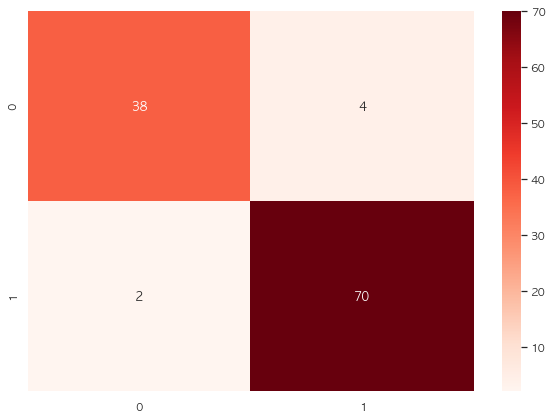

In [11]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Reds')
plt.show()

### 배깅(Vagging)

In [12]:
# 배깅 모델 생성
model_bagg = BaggingClassifier(base_estimator=model_knn, n_estimators=10, bootstrap=True, max_samples=0.5)

In [13]:
# 학습
model_bagg.fit(x_train, y_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(), max_samples=0.5)

In [14]:
# 예측
y_pred = model_bagg.predict(x_test)
y_pred

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1])

In [15]:
# f1 score
f1_score(y_test, y_pred)

0.9315068493150684

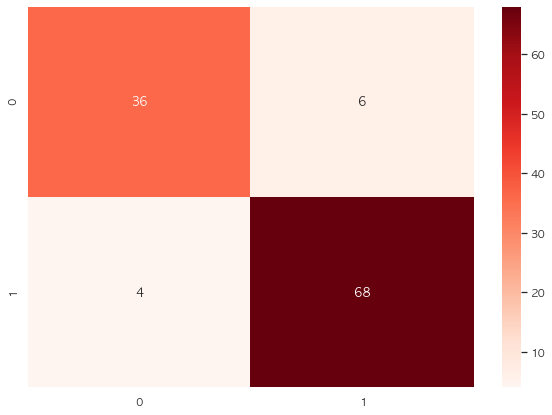

In [16]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Reds')
plt.show()

### 랜덤 포레스트(Random Forest)
- 랜덤 포레스트는 서로 상관되지 않은 트리를 활용하는 약간의 수정을 통해 배깅에 비해 개선된 성능을 나타낸다
- 배깅에서는 모든 변수를 선택하기 때문에 각 결정 트리의 분할을 위해 선택된 변수의 순서가 모든 트리에서 대체로 비슷하게 형성돼 상호간에 상관관계를 가진 것처럼 보인다
- 랜덤 포레스트는 전체 변수를 선택하는 대신 일부의 예측 변수(열)만 선택한다
- p개 변수 중 선택할 m의 값을 정하는 경험적인 법칙은 분류기 문제는 m의 값을 sqrt(p)로 사용하고, 회귀 문제는 m=p/3로 사용해 개별 트리 간의 상관관계 문제를 피한다

In [17]:
# 모델 생성
model_rforest = RandomForestClassifier()

In [18]:
# 학습
model_rforest.fit(x_train, y_train)

RandomForestClassifier()

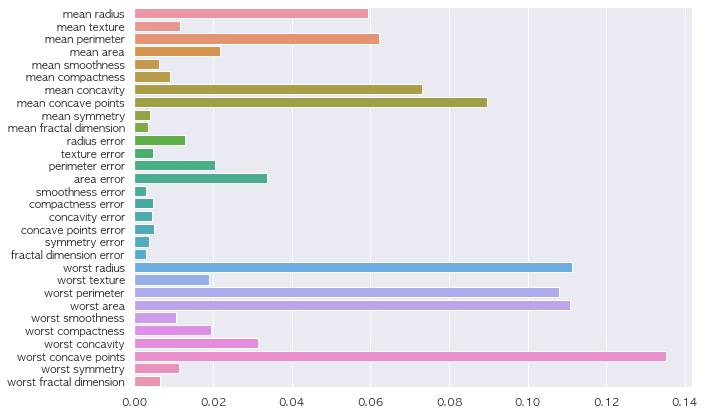

In [19]:
# 변수 중요도 시각화
sns.barplot(x=model_rforest.feature_importances_, y=b_cancer['feature_names'])
plt.show()

In [20]:
# 정확도
model_rforest.score(x_train, y_train), model_rforest.score(x_test, y_test)

(1.0, 0.9385964912280702)

In [21]:
# f1 score
f1_score(y_train, model_rforest.predict(x_train)), f1_score(y_test, model_rforest.predict(x_test))

(1.0, 0.951048951048951)

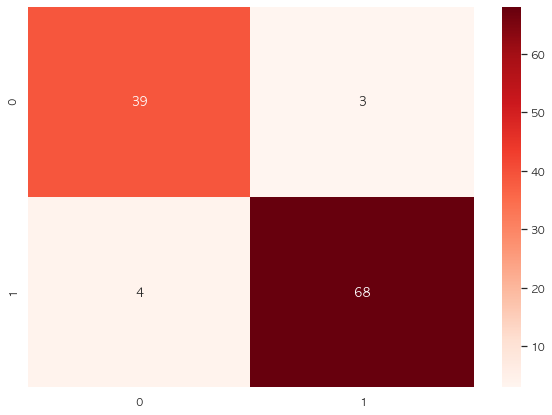

In [22]:
# confusion matrix
cm = confusion_matrix(y_test, model_rforest.predict(x_test))
sns.heatmap(cm, annot=True, cmap='Reds')
plt.show()

### 부스팅(Boosting)
- 배깅은 각 부트스트랩 과정이 독립적이므로 병렬 처리가 가능하다
- 부스팅은 순차적으로 시행되며, 부트스트랩 과정이 없다

#### 에이다 부스트(AdaBoost) 
- 처음은 단순 분류기를 데이터에 적합화하는 것으로 시작(결정 그루터기라고도 불리고, 데이터를 단 2개 영역으로 분리)
- 다음에는 가중값을 낮추고 잘못 분류된 부류들은 가중값을 높인 후 다시 결정 그루터기를 사용해 적합화
- 가중값 수정을 반복하고 반복이 끝나면 가중값에 기초해 모든 그루터기를 합쳐서 강한 분류기를 만든다

In [23]:
# 에이다 부스트의 기본 분류기로 결정 그루터기 사용 
# max_depth=1: 결정을 단 한 번만 한다는 의미 -> 매우 약한 분류기
dtree = DecisionTreeClassifier(max_depth=1, criterion='gini', random_state=0)
model_ada = AdaBoostClassifier(base_estimator=dtree, n_estimators=5000)
model_ada.fit(x_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                         random_state=0),
                   n_estimators=5000)

In [24]:
# 정확도
model_ada.score(x_train, y_train), model_rforest.score(x_test, y_test)

(1.0, 0.9385964912280702)

In [25]:
# f1 score
f1_score(y_train, model_ada.predict(x_train)), f1_score(y_test, model_ada.predict(x_test))

(1.0, 0.9655172413793104)

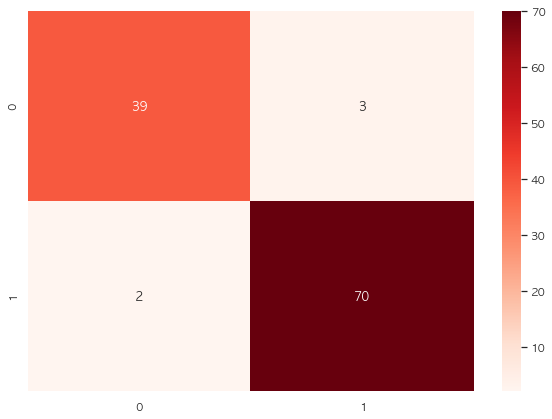

In [26]:
# confusion matrix
cm = confusion_matrix(y_test, model_ada.predict(x_test))
sns.heatmap(cm, annot=True, cmap='Reds')
plt.show()

#### 기울기 부스트(GradientBoost)
- 기본 원칙은 약한 분류기를 반복적으로 부스팅시키는 것
- 약한 분류기가 직전 반복 때 발견하기 어려웠던 문제성 관측값에 집중하게 하고 보통 의사결정 트리를 사용해 앙상블을 수행한다
- 다른 부스팅 기법처럼 모델을 단계적으로 구축해 나가는 것은 같지만 임의의 미분 가능한 손실 함수를 최적화하는 문제로 일반화할 수 있다

#### 에이다 부스팅과 기울기 부스팅의 비교
|에이다 부스트|기울기 부스트|
|:---------:|:--------:|
|이전에 잘못 분류된 관측값에 더 높은 가중값을 부여해 전환이 일어나게 한다.|이전 반복에서 큰 잔차를 남긴 관측값을 찾아낸다.|
|높은 가중값 데이터 포인트에 의해 단점을 찾아낸다.|기울기를 통해 단점을 찾아낸다|
|지수 손실 함수를 통해 적합화 정도가 나쁜 표본에 관해 더 많은 가중값이 부여된다.|기울기 부스트가 오차항을 더 분해해 더 많은 설명이 가능하다|
|기울기 부스트의 특별한 경우로 지수 손실 함수를 사용한다|기울기의 개념이 보다 더 일반적이다|


In [27]:
model_gb = GradientBoostingClassifier(n_estimators=5000, max_depth=1, min_samples_leaf=1, min_samples_split=2)
model_gb.fit(x_train, y_train)

GradientBoostingClassifier(max_depth=1, n_estimators=5000)

In [28]:
# 정확도
model_gb.score(x_train, y_train), model_gb.score(x_test, y_test)

(1.0, 0.9649122807017544)

In [29]:
# f1 score
f1_score(y_train, model_gb.predict(x_train)), f1_score(y_test, model_gb.predict(x_test))

(1.0, 0.9722222222222222)

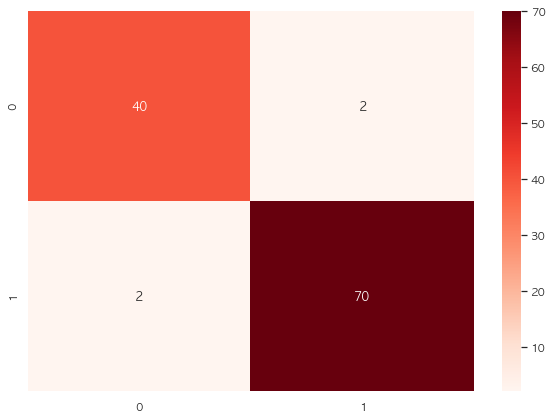

In [30]:
# confusion matrix
cm = confusion_matrix(y_test, model_gb.predict(x_test))
sns.heatmap(cm, annot=True, cmap='Reds')
plt.show()

#### 극단 기울기 부스트(XG Boost)

In [39]:
model_xg = XGBClassifier(mn_estimators=5000, max_depth=2, min_samples_leaf=1, min_samples_split=2)
model_xg.fit(x_train, y_train)

XGBClassifier(max_depth=2, min_samples_leaf=1, min_samples_split=2,
              mn_estimators=5000)

In [40]:
# 정확도
model_xg.score(x_train, y_train), model_xg.score(x_test, y_test)

(1.0, 0.9473684210526315)

In [41]:
# f1 score
f1_score(y_train, model_xg.predict(x_train)), f1_score(y_test, model_xg.predict(x_test))

(1.0, 0.9577464788732395)

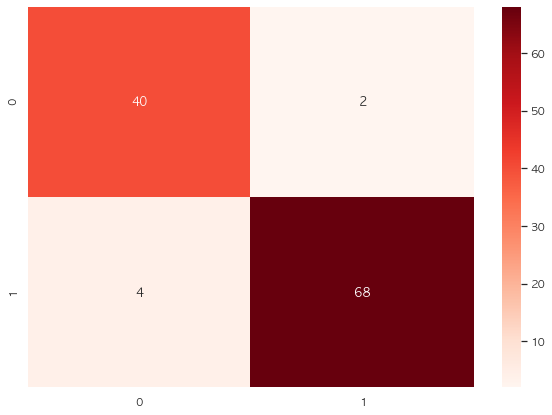

In [42]:
# confusion matrix
cm = confusion_matrix(y_test, model_xg.predict(x_test))
sns.heatmap(cm, annot=True, cmap='Reds')
plt.show()